In [20]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
from muon import atac as ac

In [9]:
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5

--2023-01-22 22:27:16--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38844318 (37M) [binary/octet-stream]
Saving to: ‘pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’

pbmc_granulocyte_so 100%[===================>]  37.04M  18.3MB/s    in 2.0s    

2023-01-22 22:27:18 (18.3 MB/s) - ‘pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5’ saved [38844318/38844318]



In [10]:
mdata = mu.read_10x_h5("pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5")

/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5


/Users/zhijianli/miniconda3/envs/pychromvar/lib/python3.9/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [11]:
mdata

MuData object with n_obs × n_vars = 2711 × 134920
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	2711 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	2711 x 98319
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [12]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 2711 × 98319
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

In [13]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

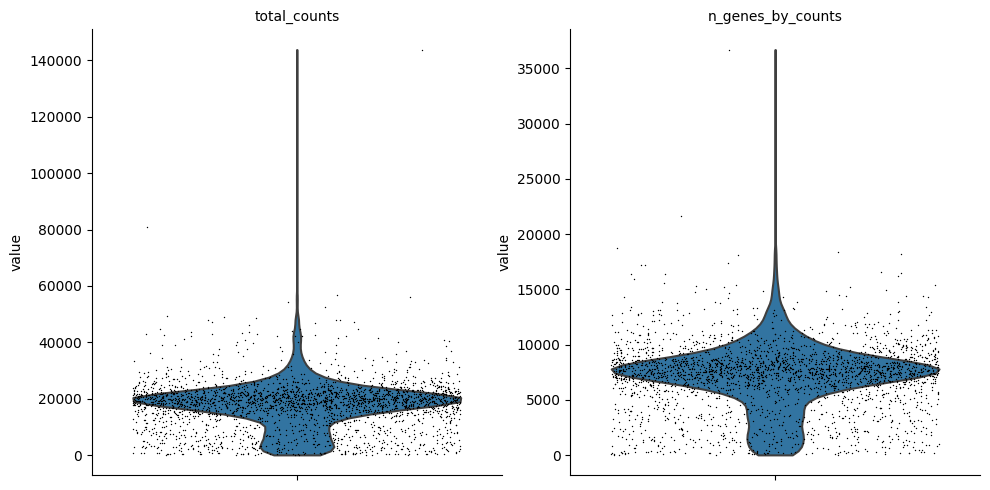

In [14]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [15]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [16]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

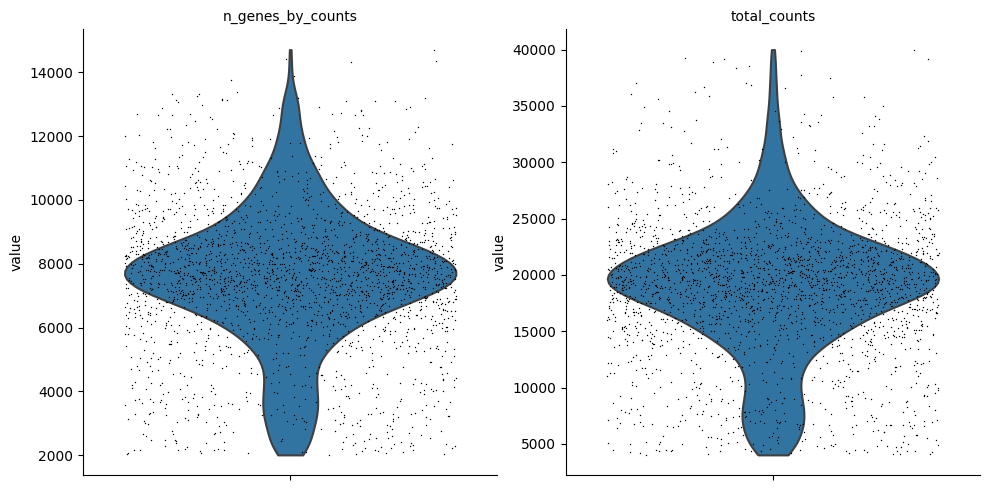

In [17]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

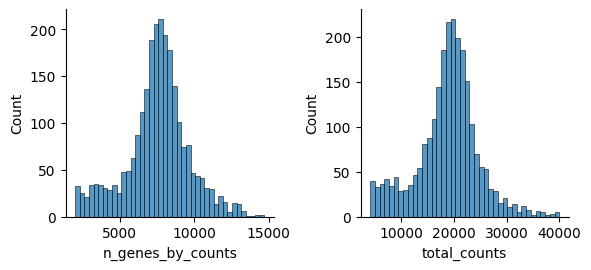

In [18]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

In [23]:
from pyjaspar import jaspardb
import pychromvar as pc

In [24]:
pc.add_peak_seq(atac, genome_file="/Users/zhijianli/rgtdata/hg38/genome_hg38.fa", delimiter=":|-")

100%|█████████████████████████████████████████████████████| 98079/98079 [00:03<00:00, 31715.32it/s]


In [25]:
pc.add_gc_bias(atac)

100%|████████████████████████████████████████████████████| 98079/98079 [00:00<00:00, 100478.40it/s]


In [26]:
atac

AnnData object with n_obs × n_vars = 2450 × 98079
    obs: 'n_genes_by_counts', 'total_counts', 'NS'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'seq'
    varm: 'gc_bias'

In [27]:
pc.get_bg_peaks(atac)

In [28]:
atac

AnnData object with n_obs × n_vars = 2450 × 98079
    obs: 'n_genes_by_counts', 'total_counts', 'NS'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'seq'
    varm: 'gc_bias', 'bg_peaks'

In [29]:
jdb_obj = jaspardb(release='JASPAR2020')
motifs = jdb_obj.fetch_motifs(
    collection = 'CORE',
    tax_group = ['vertebrates'])

In [30]:
pc.match_motif(atac, motifs=motifs)

100%|██████████████████████████████████████████████████████| 98079/98079 [01:01<00:00, 1603.57it/s]


In [ ]:
%%time
pc.compute_deviations(atac)